In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors


# load and merge data


In [2]:
sheet_names = ['Subject characteristics', 'PCs', 'GA parameters', 'Muscle impairments']
source_path = 'data/dataset.xlsx'
dfs = [pd.read_excel(source_path, sheet_name = sheet) for sheet in sheet_names]

In [3]:
def merge_dataframes(dfs):
    
    # merge files
    same_cols = ['GC_id',
                'Measurement_id',
                'Patient_id',
                'side',
                'Affected(MA=most affected; A=affected)',
                'Label ']
    
    dfs_1_2 = pd.merge(dfs[0], dfs[1], on=same_cols)
    dfs_1_2_3 = pd.merge(dfs_1_2, dfs[2], on=same_cols)
    merged_df = pd.merge(dfs_1_2_3, dfs[3].drop('Age', axis=1), on=same_cols)
    
    return merged_df

In [4]:
df_unpreprocessed = merge_dataframes(dfs)

# minimal preprocessing

In [5]:
def data_preprocessing(df):
    
    # seperate features per type
    y = df['Label '].astype(str)
    df_IDs = df.iloc[:,0:5]
    df_SCs = df.iloc[:,6:13]
    df_PCs = df.iloc[:,13:83]
    df_GAPs = df.iloc[:,83:248]
    df_MIs = df.iloc[:,248:]
    
    
    # drop specific variables that will not be used
    df_MIs = df_MIs.drop(['Side (R=0, L=1)'], axis=1)
    df_SCs = df_SCs.drop(['Exon ','LegLength','weight'], axis=1)
    
    # select the GPS features from the GAPS, the other GAP features will not be used
    df_GPS = df_GAPs[['GPS_a', 'GPS_m','GPS_p']] 
    
    # change 'Duplication ' to 'Duplication' because they are seen as different categorical values
    df_SCs.loc[df_SCs['Gene variant'] == 'Duplication ', 'Gene variant'] = 'Duplication'
    
    # delete muscle strength variables that are not normalized and/or not in comparison to the TD children
    for MI_feature_name in df_MIs.columns[16:]:
        if not(MI_feature_name.endswith('Nmkg%')):  
            df_MIs = df_MIs.drop([MI_feature_name], axis=1)
    
    # seperate MIs, rename them, and merge them back so they are grouped per muscle impairment type
    df_contractures = df_MIs[['Hip_add_ROM', 'Hip_ext_ROM','Knee_ext_ROM', 'Ham_ROM' ,'Gastroc_ROM','Soleus_ROM']]
    df_stiffness = df_MIs[['Hip_abd_stiff','Hip_flex_stiff','Knee_flex_stiff','Ham_stiff','RF_stiff','RF_length','Soleus_stiff','Gastroc_stiff']]
    df_strength = df_MIs[['HF_Nmkg%','HA_Nmkg%', 'HE_Nmkg%', 'KE_Nmkg%', 'KF_Nmkg%', 'ADF_Nmkg%','APF_Nmkg%', 'Abdominal_strength ', 'Back_strength ']]
    df_contractures.columns = ['ROM Hip adduction', 'ROM Hip extension', 'ROM Knee extension', 'ROM Hamstrings', 'ROM Gastrocnemius', 'ROM Soleus']
    df_stiffness.columns = ['Hip abductor stiffness', 'Hip flexor stiffness', 'Knee flexor stiffness', 'Hamstring stiffness', 'Rectus femoris stiffness', 'Rectus femoris length', 'Soleus stiffness', 'Gastrocnemius stiffness']
    df_strength.columns = ['Hip flexor strength', 'Hip abductor strength', 'Hip extensor strength', 'Knee extensor strength', 'Knee flexor strength', 'Dorsiflexor strength', 'Plantar flexor strength', 'Abdominal strength', 'Back strength']
    df_MIs = pd.concat([df_strength, df_contractures, df_stiffness], axis=1)
    
    # concatenate all preprocessed feature groups that can be used as input features
    df_features = pd.concat([df_SCs, df_PCs, df_GPS, df_MIs], axis=1)
    
    return pd.concat([df_IDs, df_features, y], axis=1)

In [6]:
df_unaggregated = data_preprocessing(df_unpreprocessed)

# Options for aggregating rows

### option 1: 1 datapoint = 1 measurement  & only keeping most affected side -> 137 datapoints 

In [7]:
df_MA = df_unaggregated.drop(df_unaggregated[df_unaggregated['Affected(MA=most affected; A=affected)'] == 'A'].index)  # only keep most affected side

In [8]:
# only keep most affected side and aggregate all observations of the same measurement session into one observation
# gait characteristics (PCs & GPS) are averaged for this
df_1 = df_MA.groupby('Measurement_id').aggregate({
                                                 'Measurement_id':'first','Patient_id':'first','side':'first',
                                                 'Age': 'first','BMI': 'first','height': 'first',
                                                 'Gene variant': 'first',
                                                #'Deletion': 'first','Duplication': 'first','Frameshift mutation ': 'first','Nonsense mutation': 'first','Point mutation': 'first',
                                                 'STPparameters.PC1': 'first','STPparameters.PC2': 'first','aSagP.PC1':'mean',
                                                 'aCorP.PC1':'mean','aCorP.PC2':'mean','aCorP.PC3':'mean','aTransvP.PC1':'mean','aTransvP.PC2':'mean','aTransvP.PC3':'mean','aSagH.PC1':'mean','aSagH.PC2':'mean','aCorH.PC1':'mean','aCorH.PC2':'mean','aSagK.PC1':'mean','aSagK.PC2':'mean',
                                                 'aSagK.PC3':'mean','aSagA.PC1':'mean','aTransvF.PC1':'mean','aTransvF.PC2':'mean','mSagH.PC1':'mean',
                                                 'mSagH.PC2':'mean','mSagH.PC3':'mean','mSagH.PC4':'mean','mSagH.PC5':'mean','mSagH.PC6':'mean','mSagH.PC7':'mean','pH.PC1':'mean','pH.PC2':'mean','pH.PC3':'mean','pH.PC4':'mean','pH.PC5':'mean','pH.PC6':'mean','pH.PC7':'mean','pH.PC8':'mean','pH.PC9':'mean',
                                                 'pH.PC10':'mean','mSagK.PC1':'mean','mSagK.PC2':'mean','mSagK.PC3':'mean','mSagK.PC4':'mean','mSagK.PC5':'mean','pK.PC1':'mean','pK.PC2':'mean','pK.PC3':'mean',
                                                 'pK.PC4':'mean','pK.PC5':'mean','pK.PC6':'mean','pK.PC7':'mean','pK.PC8':'mean','mSagA.PC1':'mean','mSagA.PC2':'mean','mSagA.PC3':'mean','mSagA.PC4':'mean','mSagA.PC5':'mean','mSagA.PC6':'mean','pA.PC1':'mean','pA.PC2':'mean','pA.PC3':'mean','pA.PC4':'mean','pA.PC5':'mean','pA.PC6':'mean', 'pA.PC7':'mean','pA.PC8':'mean',
                                                 'pA.PC9':'mean','pA.PC10':'mean','aSagT.PC1':'mean','aCorT.PC1':'mean','aCorT.PC2':'mean', 'aTransvT.PC1':'mean',
                                                 'aTransvT.PC2':'mean','GPS_a':'mean','GPS_m':'mean','GPS_p':'mean','Hip flexor strength':'mean','Hip abductor strength':'mean','Hip extensor strength':'mean','Knee extensor strength':'mean','Knee flexor strength':'mean','Dorsiflexor strength':'mean',
                                                 'Plantar flexor strength':'mean','Abdominal strength':'mean','Back strength':'mean','ROM Hip adduction':'mean','ROM Hip extension':'mean','ROM Knee extension':'mean','ROM Hamstrings':'mean','ROM Gastrocnemius':'mean','ROM Soleus':'mean','Hip abductor stiffness':'mean','Hip flexor stiffness':'mean',
                                                 'Knee flexor stiffness':'mean','Hamstring stiffness':'mean','Rectus femoris stiffness':'mean','Rectus femoris length':'mean','Soleus stiffness':'mean','Gastrocnemius stiffness':'mean','Label ':'first'
                                                }, index=False)

print('number of rows: ' + str(df_1.shape[0]))

number of rows: 137


### option 2: 1 datapoint = 1 side per measurement -> 2 x 137 = 274 datapoints

In [9]:
# aggregate all observations of the same measurement session and the same side into one observation
# gait characteristics (PCs & GPS) are averaged for this
df_2 = df_unaggregated.groupby(['Measurement_id', 'side']).aggregate({
                                                
                                                 'Measurement_id':'first','Patient_id':'first','side':'first',
                                                 'Age': 'first','BMI': 'first','height': 'first',
                                                 'Gene variant': 'first',
                                                #'Deletion': 'first','Duplication': 'first','Frameshift mutation ': 'first','Nonsense mutation': 'first','Point mutation': 'first',
                                                 'STPparameters.PC1': 'first','STPparameters.PC2': 'first','aSagP.PC1':'mean',
                                                 'aCorP.PC1':'mean','aCorP.PC2':'mean','aCorP.PC3':'mean','aTransvP.PC1':'mean','aTransvP.PC2':'mean','aTransvP.PC3':'mean','aSagH.PC1':'mean','aSagH.PC2':'mean','aCorH.PC1':'mean','aCorH.PC2':'mean','aSagK.PC1':'mean','aSagK.PC2':'mean',
                                                 'aSagK.PC3':'mean','aSagA.PC1':'mean','aTransvF.PC1':'mean','aTransvF.PC2':'mean','mSagH.PC1':'mean',
                                                 'mSagH.PC2':'mean','mSagH.PC3':'mean','mSagH.PC4':'mean','mSagH.PC5':'mean','mSagH.PC6':'mean','mSagH.PC7':'mean','pH.PC1':'mean','pH.PC2':'mean','pH.PC3':'mean','pH.PC4':'mean','pH.PC5':'mean','pH.PC6':'mean','pH.PC7':'mean','pH.PC8':'mean','pH.PC9':'mean',
                                                 'pH.PC10':'mean','mSagK.PC1':'mean','mSagK.PC2':'mean','mSagK.PC3':'mean','mSagK.PC4':'mean','mSagK.PC5':'mean','pK.PC1':'mean','pK.PC2':'mean','pK.PC3':'mean',
                                                 'pK.PC4':'mean','pK.PC5':'mean','pK.PC6':'mean','pK.PC7':'mean','pK.PC8':'mean','mSagA.PC1':'mean','mSagA.PC2':'mean','mSagA.PC3':'mean','mSagA.PC4':'mean','mSagA.PC5':'mean','mSagA.PC6':'mean','pA.PC1':'mean','pA.PC2':'mean','pA.PC3':'mean','pA.PC4':'mean','pA.PC5':'mean','pA.PC6':'mean', 'pA.PC7':'mean','pA.PC8':'mean',
                                                 'pA.PC9':'mean','pA.PC10':'mean','aSagT.PC1':'mean','aCorT.PC1':'mean','aCorT.PC2':'mean', 'aTransvT.PC1':'mean',
                                                 'aTransvT.PC2':'mean','GPS_a':'mean','GPS_m':'mean','GPS_p':'mean','Hip flexor strength':'mean','Hip abductor strength':'mean','Hip extensor strength':'mean','Knee extensor strength':'mean','Knee flexor strength':'mean','Dorsiflexor strength':'mean',
                                                 'Plantar flexor strength':'mean','Abdominal strength':'mean','Back strength':'mean','ROM Hip adduction':'mean','ROM Hip extension':'mean','ROM Knee extension':'mean','ROM Hamstrings':'mean','ROM Gastrocnemius':'mean','ROM Soleus':'mean','Hip abductor stiffness':'mean','Hip flexor stiffness':'mean',
                                                 'Knee flexor stiffness':'mean','Hamstring stiffness':'mean','Rectus femoris stiffness':'mean','Rectus femoris length':'mean','Soleus stiffness':'mean','Gastrocnemius stiffness':'mean','Label ':'first'
                                                }, index=False)
df_2 = pd.DataFrame(df_2.values, columns = df_2.columns)            
print('length of aggregated dataframe: ' + str(df_2.shape[0]))

length of aggregated dataframe: 274


###  option 3: 1 datapoint = 1 gait cycle -> 430 datapoints

In [10]:
print('length of unaggregated dataframe: ' + str(df_unaggregated.shape[0]))

length of unaggregated dataframe: 430


# plot structure of dataset

In [11]:
# check where label is different within one measurement
df_measurementlabels = df_2.groupby(['Measurement_id']).aggregate({'Label ':'unique'}, index=False)

for i in range(len(df_measurementlabels['Label '])):
    if (len(df_measurementlabels['Label '][i])>1):
        print(df_measurementlabels.iloc[[i]])

                Label 
Measurement_id        
DMD0016_M2      [2, 3]
                Label 
Measurement_id        
DMD0022_M1      [1, 2]


In [12]:
# construct new dataframe for the plots
df_plot = df_unaggregated.groupby(['Measurement_id']).aggregate({
                                                 'Measurement_id':'first',
                                                 'Patient_id':'first',
                                                 'Label ':'first',   
                                                 'Age': 'first',
                                                 'BMI': 'first',
                                                 'height': 'first',
                                                 'Gene variant': 'first'
                                                }, index=False)

# modify the label names for the measurement sessions with multiple labels
for i in range(len(df_plot['Label '])):
    if (df_plot['Measurement_id'][i]=='DMD0016_M2'):
        df_plot['Label '][i] = '2 & 3'
    if (df_plot['Measurement_id'][i]=='DMD0022_M1'):
        df_plot['Label '][i] = '1 & 2'
df_plot['Label '].value_counts(dropna = False)

/Users/brieklismont/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/brieklismont/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1        85
3        38
2        12
2 & 3     1
1 & 2     1
Name: Label , dtype: int64

In [13]:
# construct a variable that determines the order of the participants in the plot
df_min_age = df_unaggregated.groupby(['Patient_id']).aggregate({'Patient_id': 'first', 'Age':'min'}, index=False)
df_min_age_sorted = df_min_age.sort_values(by=['Age'])
df_min_age_sorted['order_number'] = np.arange(1, 31, 1).tolist()

In [14]:
# transfer the values of that variable to the dataframe
order_numbers = [None] * 137
for i in range(len(df_plot['Patient_id'])):
    for j in range(len(df_min_age_sorted['Patient_id'])):
        if (df_plot['Patient_id'][i] == df_min_age_sorted['Patient_id'][j]):   
            order_numbers[i] = df_min_age_sorted['order_number'][j]    
df_plot['order_number'] = order_numbers

([<matplotlib.axis.YTick at 0x7fc86c6bb650>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

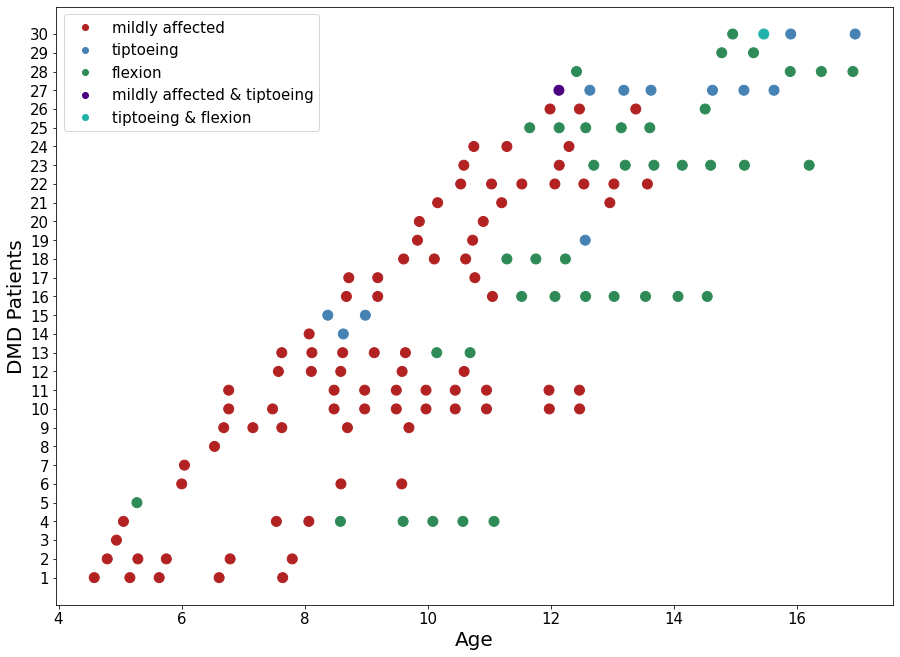

In [15]:
# plot
plt.figure(figsize=(15,11), facecolor='white')
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["firebrick", "indigo", "steelblue","lightseagreen", "seagreen"])
scatter = plt.scatter(x=df_plot['Age'],
            y=df_plot['order_number'],
            c=df_plot['Label '].astype('category').cat.codes,
            cmap = cmap, s=100)
handles = [scatter.legend_elements()[0][0],
            scatter.legend_elements()[0][2],
            scatter.legend_elements()[0][4],
            scatter.legend_elements()[0][1],
            scatter.legend_elements()[0][3]]
labels = ['mildly affected', 'tiptoeing', 'flexion', 'mildly affected & tiptoeing','tiptoeing & flexion']
plt.legend(handles=handles, labels=labels, fontsize=15)
plt.xlabel("Age", fontsize=20)
plt.ylabel("DMD Patients",fontsize=20)
ylabels = np.arange(1, 31).tolist()
plt.xticks(fontsize=15)
plt.yticks(ylabels ,fontsize=15)

# inspect missing values

In [16]:
# calculate number and proportion of NAs per column 
missing_counts = df_2.isnull().sum()
missing_counts = pd.DataFrame(missing_counts[missing_counts > 0])
missing_counts.columns = ['number of missing values']
missing_counts['missingness ratio'] = (missing_counts['number of missing values']/430 * 100).round(2)
missing_counts = missing_counts.sort_values(by = 'number of missing values', ascending=False)
print(missing_counts)

                          number of missing values  missingness ratio
Rectus femoris stiffness                       164              38.14
Hamstring stiffness                            160              37.21
Gastrocnemius stiffness                        158              36.74
Hip abductor stiffness                         158              36.74
Soleus stiffness                               158              36.74
Knee flexor stiffness                          158              36.74
Hip flexor stiffness                           158              36.74
ROM Hip adduction                               87              20.23
Hip abductor strength                           52              12.09
Hip extensor strength                           50              11.63
Hip flexor strength                             50              11.63
Back strength                                   28               6.51
Rectus femoris length                           23               5.35
Plantar flexor stren

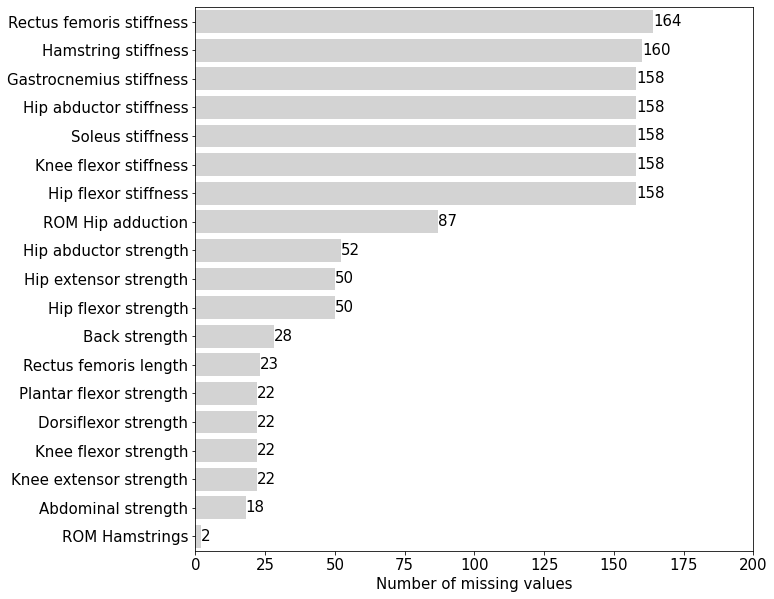

In [17]:
# make barplot of missing values
plt.figure(figsize=(10,10), facecolor='white')
        
nan_plot = sns.barplot(data= missing_counts, y = missing_counts.index, x='number of missing values', color = 'lightgray')
nan_plot.set(xlim=(0, 200)) 
    
for item in nan_plot.containers:
    nan_plot.bar_label(item, fontsize=15)
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Number of missing values", size = 15)
plt.show()


# variable descriptives 

### labels

In [18]:
df_2['Label '].value_counts(dropna = False)

1    171
3     77
2     26
Name: Label , dtype: int64

### subject characteristics


In [19]:
df_SCs = df_2.iloc[:,3:7]

In [20]:
df_SCs.iloc[:,0:3].mean() 

Age       10.642733
BMI       20.957798
height     1.237664
dtype: float64

In [21]:
df_SCs.iloc[:,0:3].median()

Age       10.619444
BMI       19.765041
height     1.243000
dtype: float64

In [22]:
df_SCs.iloc[:,0:3].min()

Age        4.580556
BMI       13.397529
height        0.996
dtype: object

In [23]:
df_SCs.iloc[:,0:3].max()

Age       16.952778
BMI        32.51133
height         1.44
dtype: object

In [24]:
df_SCs.iloc[:,0:3].std()

Age       2.922042
BMI       4.502753
height    0.104223
dtype: float64

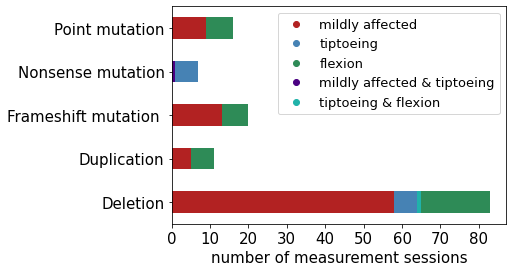

In [25]:
# plot cross table for gene variant and label
(pd.crosstab(df_plot['Gene variant'],df_plot['Label '], )
   .plot.barh(stacked=True, color={"1": "firebrick", "1 & 2": "indigo", "3": "seagreen","2": "steelblue","2 & 3": "lightseagreen",}))
plt.xlabel("number of measurement sessions", size = 15)
plt.ylabel("", size = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
labels = ['mildly affected', 'tiptoeing', 'flexion', 'mildly affected & tiptoeing','tiptoeing & flexion']
plt.legend(handles=handles, labels=labels, fontsize=13)
plt.show()

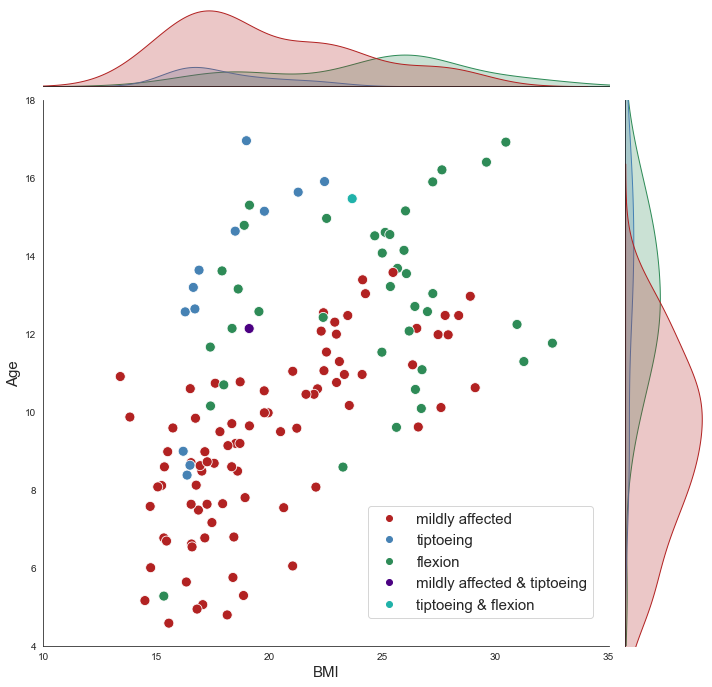

In [26]:
# plot jointplot for age, BMI, and label
sns.set_style("white")
scplot = sns.jointplot(data=df_plot, x="BMI", y="Age", hue="Label ", 
                       palette = ["firebrick", "steelblue","seagreen", "indigo","lightseagreen"],
                       xlim=(10,35), ylim=(4,18),
                       height = 10,
                       kind = 'scatter',
                       ratio = 6,
                       hue_order = ['1', '2', '3', '1 & 2', '2 & 3'],
                       s=100,
                       legend=False)
scplot.set_axis_labels('BMI', 'Age', size=15)
scplot.fig.tight_layout()
scplot.fig.subplots_adjust(top=0.95)
plt.legend(handles=handles, labels=labels, fontsize=15, loc=1, bbox_to_anchor=(-0.3,0.27))

<AxesSubplot:>

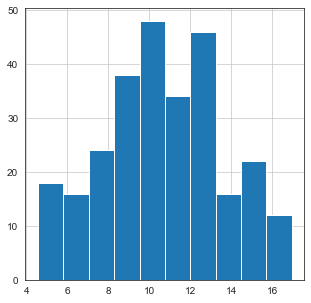

In [27]:
# histogram for age
df_SCs['Age'].hist(figsize=(5,5))

<AxesSubplot:>

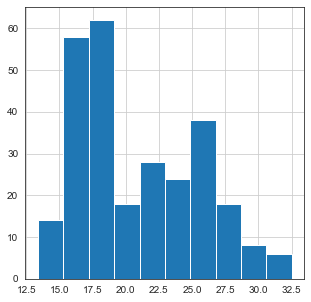

In [28]:
# histogram for bmi
df_SCs['BMI'].hist(figsize=(5,5))


<AxesSubplot:>

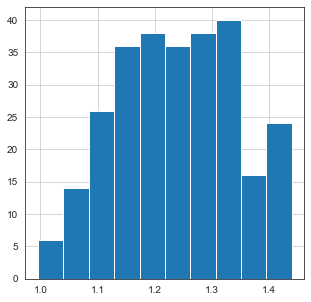

In [29]:
# histogram height
df_SCs['height'].hist(figsize=(5,5))


<AxesSubplot:xlabel='Gene variant', ylabel='count'>

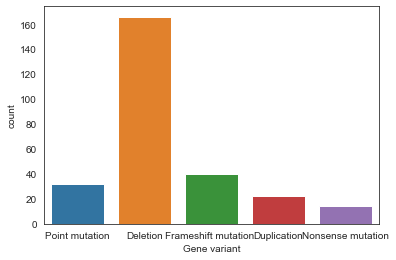

In [30]:
# countplot for gene variant
sns.countplot(x = 'Gene variant', data = df_SCs) 

### muscle impairment variables

In [31]:
df_MIs = df_2.iloc[:,80:103]

In [32]:
df_MIs.columns

Index(['Hip flexor strength', 'Hip abductor strength', 'Hip extensor strength',
       'Knee extensor strength', 'Knee flexor strength',
       'Dorsiflexor strength', 'Plantar flexor strength', 'Abdominal strength',
       'Back strength', 'ROM Hip adduction', 'ROM Hip extension',
       'ROM Knee extension', 'ROM Hamstrings', 'ROM Gastrocnemius',
       'ROM Soleus', 'Hip abductor stiffness', 'Hip flexor stiffness',
       'Knee flexor stiffness', 'Hamstring stiffness',
       'Rectus femoris stiffness', 'Rectus femoris length', 'Soleus stiffness',
       'Gastrocnemius stiffness'],
      dtype='object')

<AxesSubplot:>

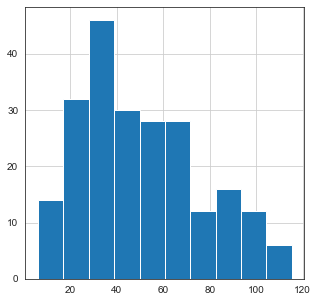

In [33]:
# histogram for one column
df_MIs['Hip flexor strength'].hist(figsize=(5,5))

<AxesSubplot:>

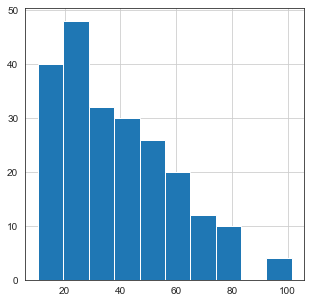

In [34]:
# histogram for Hip abductor strength
df_MIs['Hip abductor strength'].hist(figsize=(5,5))   

<AxesSubplot:>

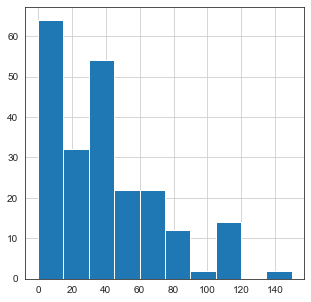

In [35]:
# histogram for Hip extensor strength
df_MIs['Hip extensor strength'].hist(figsize=(5,5))   

<AxesSubplot:>

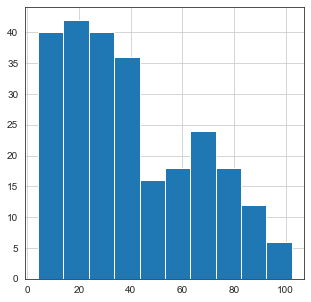

In [36]:
# histogram for Knee extensor strength
df_MIs['Knee extensor strength'].hist(figsize=(5,5))   

<AxesSubplot:>

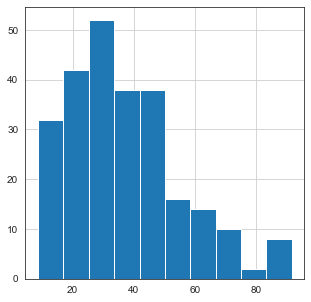

In [37]:
# histogram for Knee flexor strength
df_MIs['Knee flexor strength'].hist(figsize=(5,5))   

<AxesSubplot:>

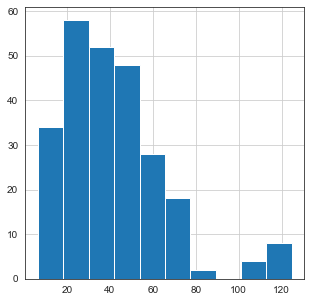

In [38]:
# histogram for Dorsiflexor strength
df_MIs['Dorsiflexor strength'].hist(figsize=(5,5))   

<AxesSubplot:>

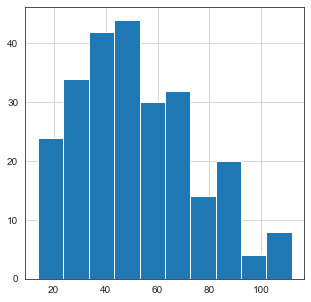

In [39]:
# histogram for Plantar flexor strength
df_MIs['Plantar flexor strength'].hist(figsize=(5,5))   

<AxesSubplot:xlabel='Back strength', ylabel='count'>

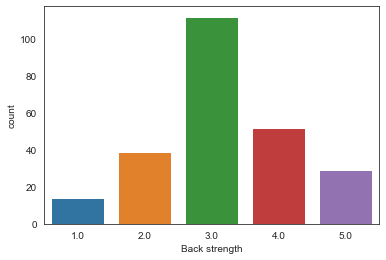

In [40]:
# countplot for Back strength
sns.countplot(x = 'Back strength', data = df_MIs)  

<AxesSubplot:xlabel='Abdominal strength', ylabel='count'>

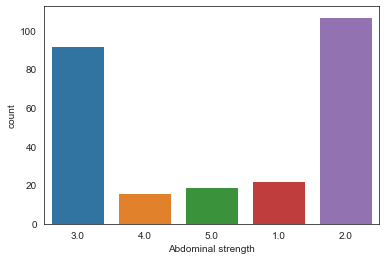

In [41]:
# countplot for Abdominal strength
sns.countplot(x = 'Abdominal strength', data = df_MIs) 

<AxesSubplot:xlabel='ROM Hip adduction', ylabel='count'>

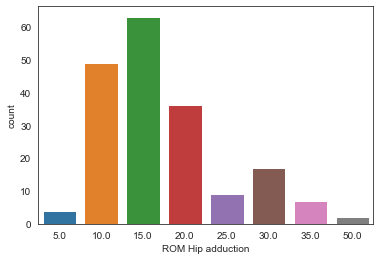

In [42]:
# countplot for ROM Hip adduction
sns.countplot(x = 'ROM Hip adduction', data = df_MIs)  

<AxesSubplot:xlabel='Hip abductor stiffness', ylabel='count'>

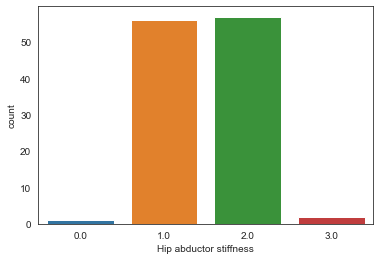

In [43]:
# countplot for Hip abductor stiffness
sns.countplot(x = 'Hip abductor stiffness', data = df_MIs)  

<AxesSubplot:xlabel='ROM Hip extension', ylabel='count'>

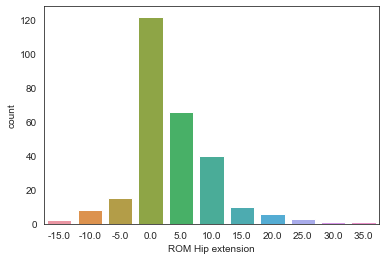

In [44]:
# countplot for ROM Hip extension
sns.countplot(x = 'ROM Hip extension', data = df_MIs)  

<AxesSubplot:xlabel='Hip flexor stiffness', ylabel='count'>

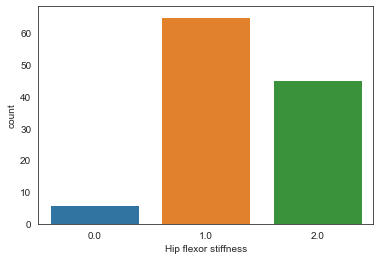

In [45]:
# countplot for Hip flexor stiffness
sns.countplot(x = 'Hip flexor stiffness', data = df_MIs)  

<AxesSubplot:xlabel='ROM Knee extension', ylabel='count'>

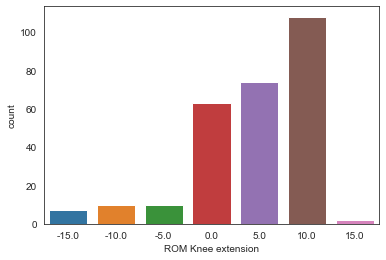

In [46]:
# countplot for ROM Knee extension
sns.countplot(x = 'ROM Knee extension', data = df_MIs)  

<AxesSubplot:xlabel='Knee flexor stiffness', ylabel='count'>

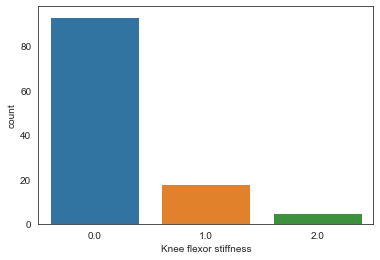

In [47]:
# countplot for Knee flexor stiffness
sns.countplot(x = 'Knee flexor stiffness', data = df_MIs)  

<AxesSubplot:xlabel='ROM Hamstrings', ylabel='count'>

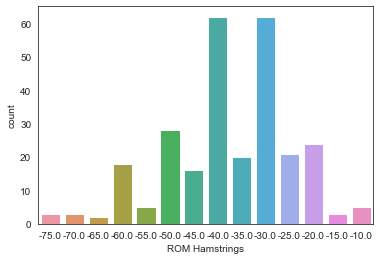

In [48]:
# countplot for ROM Hamstrings
sns.countplot(x = 'ROM Hamstrings', data = df_MIs)  

<AxesSubplot:xlabel='Hamstring stiffness', ylabel='count'>

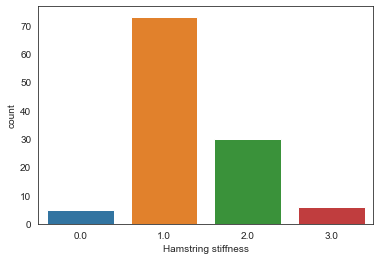

In [49]:
# countplot for Hamstring stiffness
sns.countplot(x = 'Hamstring stiffness', data = df_MIs)  

<AxesSubplot:xlabel='ROM Gastrocnemius', ylabel='count'>

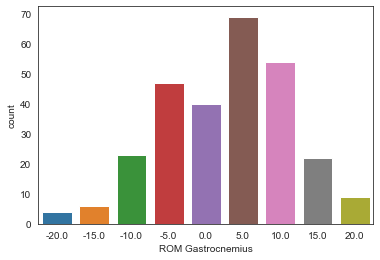

In [50]:
# countplot for ROM Gastrocnemius
sns.countplot(x = 'ROM Gastrocnemius', data = df_MIs)  

<AxesSubplot:xlabel='Gastrocnemius stiffness', ylabel='count'>

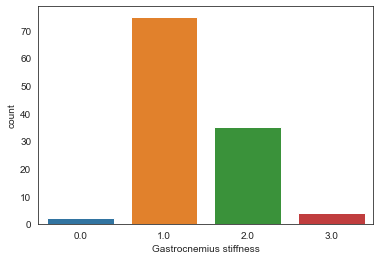

In [51]:
# countplot for Gastrocnemius stiffness
sns.countplot(x = 'Gastrocnemius stiffness', data = df_MIs)  

<AxesSubplot:xlabel='ROM Soleus', ylabel='count'>

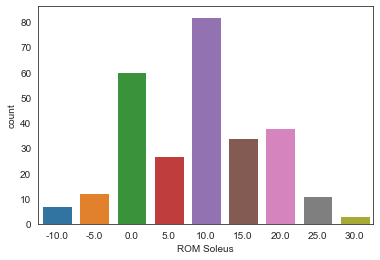

In [52]:
# countplot for ROM Soleus
sns.countplot(x = 'ROM Soleus', data = df_MIs)  

<AxesSubplot:xlabel='Soleus stiffness', ylabel='count'>

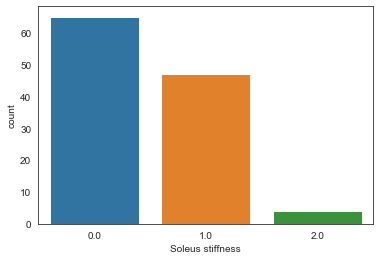

In [53]:
# countplot for Soleus stiffness
sns.countplot(x = 'Soleus stiffness', data = df_MIs)  

<AxesSubplot:xlabel='Rectus femoris stiffness', ylabel='count'>

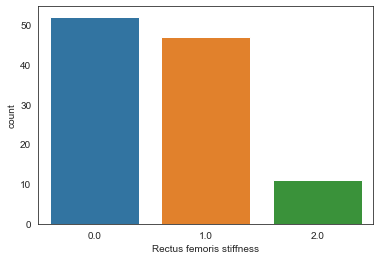

In [54]:
# countplot for Rectus femoris stiffness
sns.countplot(x = 'Rectus femoris stiffness', data = df_MIs)  

<AxesSubplot:xlabel='Rectus femoris length', ylabel='count'>

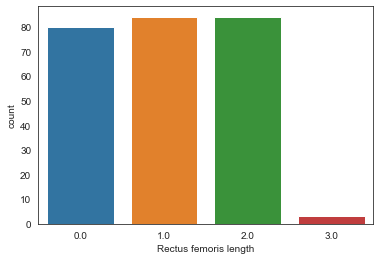

In [55]:
# countplot for Rectus femoris length
sns.countplot(x = 'Rectus femoris length', data = df_MIs)  

### gait characteristics

In [56]:
# seperate GAPs
df_GPS = df_2[['GPS_a', 'GPS_m','GPS_p']]

<AxesSubplot:>

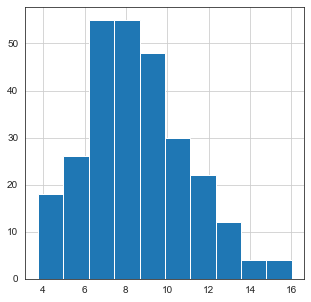

In [57]:
# histogram for GPS angle
df_GPS['GPS_a'].hist(figsize=(5,5))

<AxesSubplot:>

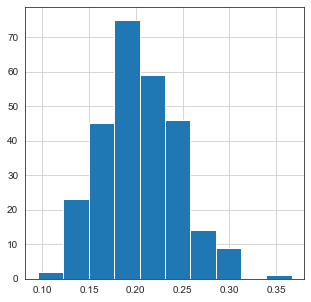

In [58]:
# histogram for GPS moment
df_GPS['GPS_m'].hist(figsize=(5,5))

<AxesSubplot:>

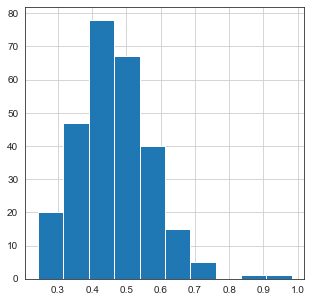

In [59]:
# histogram for GPS power
df_GPS['GPS_p'].hist(figsize=(5,5))